In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats
from scipy.stats import norm
import scipy.integrate as integrate
import matplotlib.pyplot as plt
import pickle

import gym
from gym import spaces

import random
import itertools as it
from joblib import Parallel, delayed
from toolz import memoize
from contracts import contract
from collections import namedtuple, defaultdict, deque, Counter

import warnings
warnings.filterwarnings("ignore", 
                        message="The objective has been evaluated at this point before.")

from agents import Agent
from oldmouselab import OldMouselabEnv
from policies import FixedPlanPolicy, LiederPolicy
from evaluation import *
from distributions import cmax, smax, sample, expectation, Normal, PointMass, SampleDist, Normal, Categorical

In [3]:
def save_obj(obj, name ):
    with open('data/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('data/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [4]:
def hd_dist(attributes):
    dist = [1,]*attributes
    dist[0] = np.random.randint(85,97)
    for i in range(1,attributes-1):
        dist[i] += np.random.randint(0,100-np.sum(dist))
    dist[-1] += 100-np.sum(dist)
    dist = np.around(np.array(dist)/100,decimals=2)
    np.random.shuffle(dist)
    return dist

def ld_dist(attributes):
    dist = [np.random.randint(10,40) for _ in range(attributes)]
    dist = np.around(np.array(dist)/sum(dist),decimals=2)
    np.random.shuffle(dist)
    return dist

In [5]:
gambles = 7
attributes = 4
mu_R_high_stakes = (9.99+0.01)/2
mu_R_low_stakes = (0.25+0.01)/2

sigma_R_high_stakes = 0.3*(9.99-0.01)
sigma_R_low_stakes = 0.3*(0.25-0.01)

high_stakes = Normal(mu_R_high_stakes, sigma_R_high_stakes)
low_stakes = Normal(mu_R_low_stakes, sigma_R_low_stakes)
cost=.03

n_test = 100

nr_outcomes = attributes
nr_alternatives = gambles

In [6]:
agent = Agent()
def run_env(policy, env):
    agent.register(env)
    agent.register(policy)
    tr = agent.run_episode()
#     print(tr)
    return {'util': tr['return'], 'actions': tr['actions'],
            'observations': len(tr['actions']) - 1, 'ground_truth': env.ground_truth}

def action_coordinate(env, action):
    #returns gamble, outcome
    return (action//env.outcomes,action%env.outcomes)

def p_grid(env, actions):
    grid = np.zeros((env.gambles+1,env.outcomes))
    grid[0,:] = env.dist
    for i in range(len(actions[:-1])):
        gamble, outcome = action_coordinate(env,actions[i]) 
        grid[gamble+1, outcome] = i+1
    return grid

def expected_reward_of_termination(env,actions):
    env.reset()
    for a in actions:
        env.step(a)

    return env.expected_term_reward()

def characterize_strategy(policy,envs):
    operations = []
    nr_clicks = []
    probabilities = []
    returns = []
    observations = []
    grids = []
    p_grids = []
    p_outcomes = []
    p_ranks = []
    inspected_gambles = []
    inspected_outcomes = []
    nr_inspected_outcomes = []
    best_outcome_only = []
    expected_term_rewards = []
    
    transitions_within_alternative = []
    transitions_within_attribute = []

    nr_attribute_based_clicks = np.array([])
    nr_alternative_based_clicks = np.array([])

    
    for i in range(len(envs)):
        envs[i].reset()
        trace = run_env(policy, envs[i])
        returns = returns + [trace['util']]        
        operations = operations + [trace['actions']]
        nr_clicks = nr_clicks + [len(trace['actions'])-1]
        probabilities = probabilities + [envs[i].dist]
        p_grids = p_grids + [p_grid(envs[i],trace['actions'])]
        grids = grids + [envs[i].grid()]
        
        within_attribute = []
        within_alternative = []
        
        gambles = np.array([])
        outcomes = np.array([])
        observed_payoffs = np.array([])
                
        p_outcome = np.array([])
        p_rank = np.array([])
        array = -envs[i].dist
        temp = array.argsort()
        ranks = np.empty_like(temp)
        ranks[temp] = np.arange(len(array))+1
        #print(ranks)
        
        for a in trace['actions'][:-1]:
            gamble, outcome = action_coordinate(envs[i], a)
            gambles = np.append(gambles,[gamble])
            outcomes = np.append(outcomes,[outcome])
            p_outcome = np.append(p_outcome,[envs[i].dist[outcome]])
            p_rank = np.append(p_rank,[ranks[outcome]])
            observed_payoffs = np.append(observed_payoffs,trace['ground_truth'][a])
        
        
        clicks = trace['actions'][:-1]
        for c in np.arange(1,len(clicks)):
            prev_click = clicks[c-1]
            prev_gamble,prev_attribute = action_coordinate(envs[i], prev_click)
            gamble,attribute =  action_coordinate(envs[i], clicks[c])
            within_attribute = within_attribute + [attribute==prev_attribute]
            within_alternative = within_alternative + [gamble==prev_gamble]
        
        p_ranks = p_ranks + [p_rank]
        
        transitions_within_alternative = transitions_within_alternative + [within_alternative]
        transitions_within_attribute = transitions_within_attribute + [within_attribute]

        nr_attribute_based_clicks   = np.append(nr_attribute_based_clicks,[np.sum(within_attribute)])
        nr_alternative_based_clicks = np.append(nr_alternative_based_clicks,[np.sum(within_alternative)])
        
        best_outcome_only.append(np.all(np.unique(p_rank)==[1]))        
        observations = observations + [observed_payoffs]
        expected_term_rewards = expected_term_rewards  + [expected_reward_of_termination(envs[i],trace['actions'][:-1])] 
        p_outcomes = p_outcomes + [p_outcome]
        inspected_gambles = inspected_gambles + [gambles]
        inspected_outcomes= inspected_outcomes + [outcomes]
        nr_inspected_outcomes = nr_inspected_outcomes + [len(np.unique(outcomes))]
    
    return {'grids':grids,'expected_term_rewards': expected_term_rewards,'best_outcome_only': best_outcome_only,
            'nr_inspected_outcomes':nr_inspected_outcomes, 'p_ranks': p_ranks, 'p_outcomes': p_outcomes, 
            'inspected_gambles': inspected_gambles, 'inspected_outcomes': inspected_outcomes, 'p_grids': p_grids,
            'returns': returns, 'observations': observations, 'operations':operations, 'nr_clicks': nr_clicks,
            'nr_alternative_based_clicks':nr_alternative_based_clicks,'nr_attribute_based_clicks':nr_attribute_based_clicks,
            'transitions_within_attribute': transitions_within_attribute, 'transitions_within_alternative': transitions_within_alternative,'probabilities': probabilities}
    

# High stakes, high dispersion

In [52]:
#bo_pol_theta = np.load('data/high_stakes_3cents.npy')
bo_pol_theta = np.load('data/high_stakes_1cents.npy')
bo_pol_high_stakes = LiederPolicy(list(bo_pol_theta))

cost = 0.01
reward = high_stakes
hd_hs_envs =  [OldMouselabEnv(gambles, hd_dist(attributes), reward, cost) for _ in range(n_test)]
term_action = hd_hs_envs[0].term_action

In [53]:
#hd_hs = characterize_strategy(bo_pol_high_stakes, hd_hs_envs)
#save_obj(hd_hs,'high_dispersion_high_stakes_1cents')
#save_obj(hd_hs_envs,'hd_hs_envs_0.5cents')
#hd_hs = load_obj('high_dispersion_high_stakes')
hd_hs=load_obj('high_dispersion_high_stakes_1cents')

In [8]:
max_EV = np.array([])
all_actions = np.arange(28)
#for a in all_actions:
#    test_envs_hd[0].step(a)

for i in range(len(hd_hs_envs)):
    max_EV = np.append(max_EV,[expected_reward_of_termination(hd_hs_envs[i],all_actions)])
    
max_EV_hd_hs = np.mean(max_EV)

print("The resource-rational strategy reaps {:.4}% of the highest possible payoffs.".format(100*np.mean(hd_hs['returns'])/max_EV_hd_hs))

The resource-rational strategy reaps 102.3% of the highest possible payoffs.


In [9]:
TTB_compatible = np.array([])
WADD_compatible = np.array([])
SAT_TTB_compatible = np.array([])
random_choice = np.array([])

for i in range(n_test):
    TTB_compatible =  np.append(TTB_compatible, [hd_hs['nr_clicks'][i]==nr_alternatives and hd_hs['best_outcome_only'][i]])
    WADD_compatible=  np.append(WADD_compatible,[hd_hs['nr_clicks'][i]==nr_alternatives*nr_outcomes])
    SAT_TTB_compatible = np.append(SAT_TTB_compatible, [hd_hs['best_outcome_only'][i] and hd_hs['nr_clicks'][i]>0])
    random_choice = np.append(random_choice, [hd_hs['nr_clicks'][i]==0])

print("On {}% of the high-dispersion trials the resource-rational strategy is random choice.".format(100*np.mean(random_choice)))
print("On {}% of the high-dispersion trials the click squences of the high-stakes policy were consistent with SAT-TTB.".format(100*np.mean(SAT_TTB_compatible)))
print("On {}% of the high-dispersion trials the click squences of the high-stakes policy were consistent with TTB.".format(100*np.mean(TTB_compatible)))
print("On {}% of the high-dispersion trials the click squences of the high-stakes policy was consistent with WADD.".format(100*np.mean(WADD_compatible)))

On 0.0% of the high-dispersion trials the resource-rational strategy is random choice.
On 90.0% of the high-dispersion trials the click squences of the high-stakes policy were consistent with SAT-TTB.
On 77.0% of the high-dispersion trials the click squences of the high-stakes policy were consistent with TTB.
On 0.0% of the high-dispersion trials the click squences of the high-stakes policy was consistent with WADD.


In [10]:
print("The high-stakes policy inspected more than 7 cells in {}% of the trials.".format(100*np.mean(np.array(hd_hs['nr_clicks'])>7)))
print("The high-stakes policy inspected more than 1 outcome in {}% of the high-dispersion trials.".format(100*np.mean(np.array(hd_hs['nr_inspected_outcomes'])>1)))

The high-stakes policy inspected more than 7 cells in 10.0% of the trials.
The high-stakes policy inspected more than 1 outcome in 10.0% of the high-dispersion trials.


False
In   90.0% of the high-dispersion problems, the high-stakes policy considered only the most probably outcome.

In the high-dispersion environment the BO policy made between 4 and 10 clicks. The average number of clicks was 7.0.

 Example: 
[[ 0.06  0.06  0.85  0.03]
 [ 0.    9.    5.    0.  ]
 [ 0.    0.    4.    0.  ]
 [ 0.    0.    2.    0.  ]
 [ 0.    0.    7.    0.  ]
 [ 0.    0.    3.    0.  ]
 [ 0.    8.    1.    0.  ]
 [ 0.    0.    6.    0.  ]]
[[  4.688   3.463   8.583   1.015]
 [  2.717   3.802   7.603  10.049]
 [  5.929   7.528   7.567  12.152]
 [  7.488   7.925  -0.727  -1.613]
 [  1.239   7.209   5.663   8.446]
 [  2.055   4.487   5.698   8.765]
 [  5.564   7.986   7.423   5.673]]


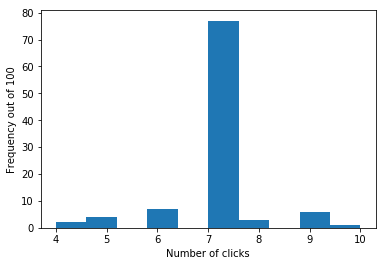

In [11]:
print(np.all(hd_hs['best_outcome_only']))

print("In {:6.3}% of the high-dispersion problems, the high-stakes policy considered only the most probably outcome.".format(100*np.mean(hd_hs['best_outcome_only'])))
print("")
avg_nr_clicks_hd_hs=np.mean(hd_hs['nr_clicks'])
min_nr_clicks_hd_hs=np.min(hd_hs['nr_clicks'])
max_nr_clicks_hd_hs=np.max(hd_hs['nr_clicks'])

print('In the high-dispersion environment the BO policy made between {} and {} clicks. The average number of clicks was {:3.2}.'.format(min_nr_clicks_hd_hs,max_nr_clicks_hd_hs,avg_nr_clicks_hd_hs))

plt.figure()
plt.hist(hd_hs['nr_clicks'])
plt.xlabel('Number of clicks')
plt.ylabel('Frequency out of 100')

print("\n Example: ")
print(hd_hs['p_grids'][1])
print(hd_hs_envs[1].grid())

The high-stakes policy inspected more than 1 outcome in 10.0% of the high-dispersion trials.
The high-stakes policy inspected all 4 outcomes in 0.0% of the high-dispersion trials.


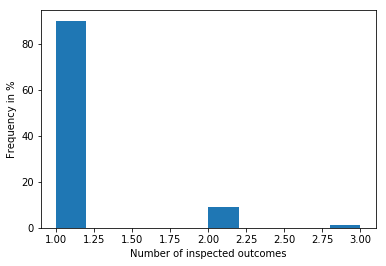

In [12]:
plt.figure()
plt.hist(hd_hs['nr_inspected_outcomes'])
plt.xlabel('Number of inspected outcomes')
plt.ylabel('Frequency in %')

#print("The high-stakes policy inspected more than 7 cells in {}% of the low-dispersion trials.".format(100*np.mean(np.array(ld_hs['nr_clicks'])>7)))
print("The high-stakes policy inspected more than 1 outcome in {}% of the high-dispersion trials.".format(100*np.mean(np.array(hd_hs['nr_inspected_outcomes'])>1)))
print("The high-stakes policy inspected all 4 outcomes in {}% of the high-dispersion trials.".format(100*np.mean(np.array(hd_hs['nr_inspected_outcomes'])==4)))


In [13]:
prop_alternative_based_clicks = np.mean(np.array(hd_hs['nr_alternative_based_clicks'])/(np.array(hd_hs['nr_clicks'])-1))
prop_attribute_based_clicks = np.mean(np.array(hd_hs['nr_attribute_based_clicks'])/(np.array(hd_hs['nr_clicks'])-1))
prop_other = 1 - (prop_alternative_based_clicks + prop_attribute_based_clicks)
#hd_hs['transitions_within_alternative']

print('In the high-dispersion environment {:.4}% of the clicks transitioned within the same attribute, {:.4}% transitioned within the same alternative, and the remaining {:.4}% of clicks switched both the attribute and the alternative.'.format(100*prop_attribute_based_clicks,100*prop_alternative_based_clicks,100*prop_other))

In the high-dispersion environment 98.6% of the clicks transitioned within the same attribute, 0.4107% transitioned within the same alternative, and the remaining 0.9901% of clicks switched both the attribute and the alternative.


Aspiration level after 4 clicks: 11.154238765763745
Aspiration level after 5 clicks: 11.127358827519275
Aspiration level after 6 clicks: 10.267506528050697
Aspiration level after 7 clicks: 5.9104971446208525
Aspiration level after 8 clicks: 6.241637110239201
average aspiration level: $10.3
average aspiration level: 1.76 standard deviations above mean


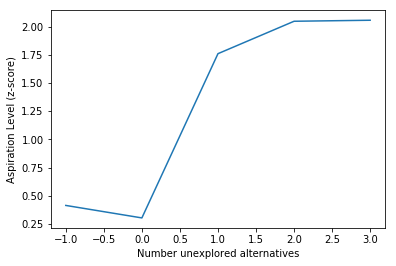

In [14]:
click_nrs = np.unique(hd_hs['nr_clicks'])
nr_clicks = np.array(hd_hs['nr_clicks'])
expected_returns = np.array(hd_hs['expected_term_rewards'])

aspiration_levels = dict()

for n in click_nrs[:-2]:
    print("Aspiration level after {} clicks: {}".format(n,np.min(expected_returns[nr_clicks==n])))
    aspiration_levels[n] = (np.min(expected_returns[nr_clicks==n])-mu_R_high_stakes)/sigma_R_high_stakes

plt.figure()
plt.plot(nr_alternatives-np.array([float(val) for val in aspiration_levels.keys()]),aspiration_levels.values())
plt.ylabel('Aspiration Level (z-score)')
plt.xlabel('Number unexplored alternatives')

#hd_hs['observations'][2]

aspiration_level = np.min(expected_returns[np.array(hd_hs['nr_clicks'])<nr_alternatives])
print('average aspiration level: ${:.3}'.format(aspiration_level))
print('average aspiration level: {:.3} standard deviations above mean'.format((aspiration_level-mu_R_high_stakes)/sigma_R_high_stakes))

In [15]:
#Save the results
save_obj(hd_hs, 'high_dispersion_high_stakes' )

# High stakes, low dispersion

In [16]:
bo_pol_theta = np.load('data/high_stakes_3cents.npy')
bo_pol_high_stakes = LiederPolicy(list(bo_pol_theta))

reward = high_stakes
ld_hs_envs = [OldMouselabEnv(gambles, ld_dist(attributes), reward, cost) for _ in range(n_test)]

term_action = ld_hs_envs[0].term_action

In [17]:
#ld_hs = characterize_strategy(bo_pol_high_stakes,ld_hs_envs)
#save_obj(ld_hs,'low_dispersion_high_stakes_1cents')
ld_hs = load_obj('low_dispersion_high_stakes_1cents')

In [18]:
max_EV = np.array([])
all_actions = np.arange(28)
#for a in all_actions:
#    test_envs_hd[0].step(a)

for i in range(len(ld_hs_envs)):
    max_EV = np.append(max_EV,[expected_reward_of_termination(ld_hs_envs[i],all_actions)])
    
max_EV_ld_hs = np.mean(max_EV)

np.mean(ld_hs['returns'])/max_EV_ld_hs

print("The resource-rational strategy reaps {:.4}% of the highest possible payoffs.".format(100*np.mean(ld_hs['returns'])/max_EV_ld_hs))

The resource-rational strategy reaps 92.59% of the highest possible payoffs.


In [19]:
TTB_compatible = np.array([])
WADD_compatible = np.array([])
SAT_TTB_compatible = np.array([])
random_choice = np.array([])

for i in range(n_test):
    TTB_compatible =  np.append(TTB_compatible, [ld_hs['nr_clicks'][i]==nr_alternatives and ld_hs['best_outcome_only'][i]])
    WADD_compatible=  np.append(WADD_compatible,[ld_hs['nr_clicks'][i]==nr_alternatives*nr_outcomes])
    SAT_TTB_compatible = np.append(SAT_TTB_compatible, [ld_hs['best_outcome_only'][i] and ld_hs['nr_clicks'][i]>0])
    random_choice = np.append(random_choice, [ld_hs['nr_clicks'][i]==0])

print("On {}% of the low-dispersion trials the resource-rational strategy is random choice.".format(100*np.mean(random_choice)))
print("On {}% of the low-dispersion trials the click squences of the high-stakes policy were consistent with SAT-TTB.".format(100*np.mean(SAT_TTB_compatible)))
print("On {}% of the low-dispersion trials the click squences of the high-stakes policy were consistent with TTB.".format(100*np.mean(TTB_compatible)))
print("On {}% of the low-dispersion trials the click squences of the high-stakes policy was consistent with WADD.".format(100*np.mean(WADD_compatible)))


On 0.0% of the low-dispersion trials the resource-rational strategy is random choice.
On 0.0% of the low-dispersion trials the click squences of the high-stakes policy were consistent with SAT-TTB.
On 0.0% of the low-dispersion trials the click squences of the high-stakes policy were consistent with TTB.
On 0.0% of the low-dispersion trials the click squences of the high-stakes policy was consistent with WADD.


In [20]:
prop_alternative_based_clicks = np.mean(np.array(ld_hs['nr_alternative_based_clicks'])/(np.array(ld_hs['nr_clicks'])-1))
prop_attribute_based_clicks = np.mean(np.array(ld_hs['nr_attribute_based_clicks'])/(np.array(ld_hs['nr_clicks'])-1))
prop_other = 1 - (prop_alternative_based_clicks + prop_attribute_based_clicks)
#ld_hs['transitions_within_alternative']

print('In the low-dispersion environment {:.4}% of the clicks transitioned within the same attribute, {:.4}% transitioned within the same alternative, and the remaining {:.4}% of clicks switched both the attribute and the alternative.'.format(100*prop_attribute_based_clicks,100*prop_alternative_based_clicks,100*prop_other))

In the low-dispersion environment 46.13% of the clicks transitioned within the same attribute, 14.88% transitioned within the same alternative, and the remaining 38.99% of clicks switched both the attribute and the alternative.


The high-stakes policy inspected more than 1 outcome in 100.0% of the low-dispersion trials.
The high-stakes policy inspected all 4 outcomes in 56.00000000000001% of the low-dispersion trials.


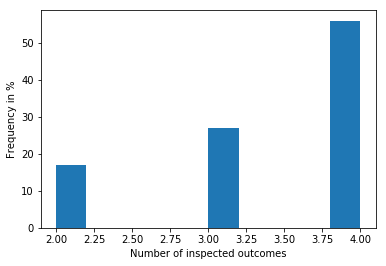

In [21]:
plt.figure()
plt.hist(ld_hs['nr_inspected_outcomes'])
plt.xlabel('Number of inspected outcomes')
plt.ylabel('Frequency in %')

#print("The high-stakes policy inspected more than 7 cells in {}% of the low-dispersion trials.".format(100*np.mean(np.array(ld_hs['nr_clicks'])>7)))
print("The high-stakes policy inspected more than 1 outcome in {}% of the low-dispersion trials.".format(100*np.mean(np.array(ld_hs['nr_inspected_outcomes'])>1)))
print("The high-stakes policy inspected all 4 outcomes in {}% of the low-dispersion trials.".format(100*np.mean(np.array(ld_hs['nr_inspected_outcomes'])==4)))


In    0.0% of the low-dispersion problems, the high-stakes policy considered only the most probably outcome.

In the low-dispersion environment the BO policy made between 5 and 21 clicks. The average number of clicks was 12.8.

 Example: 
[[ 0.172  0.323  0.172  0.333]
 [ 0.     3.     0.     0.   ]
 [ 0.     8.     0.     9.   ]
 [ 0.     0.     0.     0.   ]
 [ 0.     0.     0.     2.   ]
 [ 0.     4.     0.     5.   ]
 [ 0.     6.     0.     1.   ]
 [ 0.     7.     0.     0.   ]]
[[ 4.561  5.685  8.157  4.688]
 [ 4.764  6.718  7.19   7.078]
 [ 8.848  4.619  9.4    8.088]
 [ 0.817  1.34   2.544  0.905]
 [ 7.231  5.473  1.215  8.027]
 [-2.684  6.776  2.821  3.228]
 [ 4.61   7.544  5.111 -2.348]]


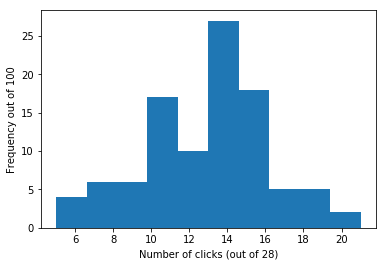

In [22]:
print("In {:6.3}% of the low-dispersion problems, the high-stakes policy considered only the most probably outcome.".format(100*np.mean(ld_hs['best_outcome_only'])))
print("")
avg_nr_clicks_ld_hs=np.mean(ld_hs['nr_clicks'])
min_nr_clicks_ld_hs=np.min(ld_hs['nr_clicks'])
max_nr_clicks_ld_hs=np.max(ld_hs['nr_clicks'])

print('In the low-dispersion environment the BO policy made between {} and {} clicks. The average number of clicks was {:4.3}.'.format(min_nr_clicks_ld_hs,max_nr_clicks_ld_hs,avg_nr_clicks_ld_hs))

plt.figure()
plt.hist(ld_hs['nr_clicks'])
plt.xlabel('Number of clicks (out of 28)')
plt.ylabel('Frequency out of 100')

print("\n Example: ")
print(ld_hs['p_grids'][4])
print(ld_hs_envs[4].grid())

## Properties of the high-stakes strategy in the low-dispersion environment

In high-stakes decision problems where all outcomes are almost equally likely, the LC policy does not seem to correspond to any previously proposed decision strategy. Its click sequence agreed with TTB on only 1% of the decision problems, and it corresponded to WADD on 0/100 problems.

Instead, it appears to shift between searching for promising alternatives and evaluating them in detail until it finds an alternative that it deems good enough. Inspecting its click-sequences suggested the following description:
1. It starts inspected payoffs for the most likely outcome until it has found at least two promising gambles.
1. It then aspects the payoffs of those gambles for the second most likely outcome.
1. If those are similar and worse, then it continues to inspect the payoffs of these gambles for the third most likely outcome.
1. When the gambles look no longer promising, it starts inspecting other gambles.
1. If one of them has a promising payoff, it will collect more information about that gamble.
1. If nothing is covnincing yet, it will inspect yet another new gamble.
1. It stops when it becomes too unlikely that something better than the current best will be found eventually.

In more quantitative terms, I found that the resource-rational strategy for environments were all outcomes are almost equally likely is qualitatively different from its counterpart for the environment where one outcome is much more likely than all others. Concretely, in contrast to the resource-rational strategy for the environment with high dispersion, this strategy was predominantly compensatory in that it considered more than 1 outcome for 98% of the problems. In fact, it considered all four possible outcomes in 67% of the decisions. Furthermore, the resource-rational strategy collected significantly more information in the low-dispersion environment  than in the high dispersion environment.
Concretely, in the low-dispersion environment, it considered about 13 of the 28 payoffs on average (range: 5–21).

As before, there was a trend for the strategy’s aspiration level to decrease as the number of unknown payoffs decreased.

Aspiration level after 5 clicks: 7.8908479593171
Aspiration level after 6 clicks: 8.109105107984629
Aspiration level after 7 clicks: 8.552317393590382
Aspiration level after 8 clicks: 6.3068420579255795
Aspiration level after 9 clicks: 7.501574410356419
Aspiration level after 10 clicks: 6.259937526838719
Aspiration level after 11 clicks: 5.854305501011204
Aspiration level after 12 clicks: 5.587765789560521
Aspiration level after 13 clicks: 5.578664540588791
Aspiration level after 14 clicks: 5.7786858958532505
Aspiration level after 15 clicks: 6.043591131073287
Aspiration level after 16 clicks: 6.057183744193917
Aspiration level after 17 clicks: 5.677364259457916
Aspiration level after 18 clicks: 5.95217845486502
average aspiration level: $6.93
average aspiration level: 0.643 standard deviations above mean


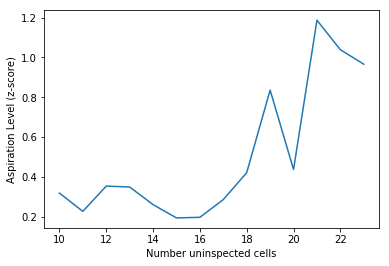

In [23]:
click_nrs = np.unique(ld_hs['nr_clicks'])
nr_clicks = np.array(ld_hs['nr_clicks'])
expected_returns = np.array(ld_hs['expected_term_rewards'])

aspiration_levels = dict()

for n in click_nrs[:-2]:
    print("Aspiration level after {} clicks: {}".format(n,np.min(expected_returns[nr_clicks==n])))
    aspiration_levels[n] = (np.min(expected_returns[nr_clicks==n])-mu_R_high_stakes)/sigma_R_high_stakes

plt.figure()
plt.plot(nr_alternatives*nr_outcomes-np.array([float(val) for val in aspiration_levels.keys()]),aspiration_levels.values())
plt.ylabel('Aspiration Level (z-score)')
plt.xlabel('Number uninspected cells')

aspiration_level = np.min(expected_returns[np.array(ld_hs['nr_clicks'])<nr_alternatives])
print('average aspiration level: ${:.3}'.format(np.mean(expected_returns)))
print('average aspiration level: {:.3} standard deviations above mean'.format((np.mean(expected_returns)-mu_R_high_stakes)/sigma_R_high_stakes))

# Low stakes, high dispersion

In [24]:
bo_pol_theta = np.load('data/low_stakes_1cents.npy')
bo_pol_low_stakes = LiederPolicy(list(bo_pol_theta))

cost=.01
reward = low_stakes
hd_ls_envs =  [OldMouselabEnv(gambles, hd_dist(attributes), reward, cost) for _ in range(n_test)]

term_action = hd_ls_envs[0].term_action

In [25]:
#hd_ls = characterize_strategy(bo_pol_low_stakes,hd_ls_envs)
#save_obj(hd_ls,'high_dispersion_low_stakes_1cents')
hd_ls=load_obj('high_dispersion_low_stakes_1cents')
#hd_ls = load_obj('high_dispersion_low_stakes_0.5cents')
#save_obj(hd_ls,'high_dispersion_low_stakes_3cents')

In [26]:
max_EV = np.array([])
all_actions = np.arange(28)
#for a in all_actions:
#    test_envs_hd[0].step(a)

for i in range(len(hd_ls_envs)):
    max_EV = np.append(max_EV,[expected_reward_of_termination(hd_ls_envs[i],all_actions)])
    
max_EV_hd_ls = np.mean(max_EV)

np.mean(hd_ls['returns'])/max_EV_hd_ls

print("The resource-rational strategy reaps {:.4}% of the highest possible payoffs.".format(100*np.mean(hd_ls['returns'])/max_EV_hd_ls))

The resource-rational strategy reaps 75.04% of the highest possible payoffs.


In [27]:
TTB_compatible = np.array([])
WADD_compatible = np.array([])
SAT_TTB_compatible = np.array([])
random_choice = np.array([])

for i in range(n_test):
    TTB_compatible =  np.append(TTB_compatible, [hd_ls['nr_clicks'][i]==nr_alternatives and hd_ls['best_outcome_only'][i]])
    WADD_compatible=  np.append(WADD_compatible,[hd_ls['nr_clicks'][i]==nr_alternatives*nr_outcomes])
    SAT_TTB_compatible = np.append(SAT_TTB_compatible, [hd_ls['best_outcome_only'][i] and hd_ls['nr_clicks'][i]>0])
    random_choice = np.append(random_choice, [hd_ls['nr_clicks'][i]==0])

print("On {}% of the high-dispersion trials the resource-rational strategy is random choice.".format(100*np.mean(random_choice)))
print("On {}% of the high-dispersion trials the click squences of the low-stakes policy were consistent with SAT-TTB.".format(100*np.mean(SAT_TTB_compatible)))
print("On {}% of the high-dispersion trials the click squences of the low-stakes policy were consistent with TTB.".format(100*np.mean(TTB_compatible)))
print("On {}% of the high-dispersion trials the click squences of the low-stakes policy was consistent with WADD.".format(100*np.mean(WADD_compatible)))

On 0.0% of the high-dispersion trials the resource-rational strategy is random choice.
On 100.0% of the high-dispersion trials the click squences of the low-stakes policy were consistent with SAT-TTB.
On 21.0% of the high-dispersion trials the click squences of the low-stakes policy were consistent with TTB.
On 0.0% of the high-dispersion trials the click squences of the low-stakes policy was consistent with WADD.


In [28]:
prop_alternative_based_clicks = np.mean(np.array(hd_ls['nr_alternative_based_clicks'])/(np.array(hd_ls['nr_clicks'])-1+0.00000000001))
prop_attribute_based_clicks = np.mean(np.array(hd_ls['nr_attribute_based_clicks'])/(np.array(hd_ls['nr_clicks'])-1+0.00000000001))
prop_other = 1 - (prop_alternative_based_clicks + prop_attribute_based_clicks)
#hd_ls['transitions_within_alternative']

print('In the high-dispersion environment {:.4}% of the clicks transitioned within the same attribute, {:.4}% transitioned within the same alternative, and the remaining {:.4}% of clicks switched both the attribute and the alternative.'.format(100*prop_attribute_based_clicks,100*prop_alternative_based_clicks,100*prop_other))

In the high-dispersion environment 80.0% of the clicks transitioned within the same attribute, 0.0% transitioned within the same alternative, and the remaining 20.0% of clicks switched both the attribute and the alternative.


0
The low-stakes policy inspected exactly 7 cells in 21.0% of the high-dispersion trials.
The low-stakes policy inspected fewer than 7 cells in 79.0% of the high-dispersion trials.
The low-stakes policy inspected more than 7 cells in 0.0% of the high-dispersion trials.
The low-stakes policy inspected more than 1 outcome in 0.0% of the high-dispersion trials.


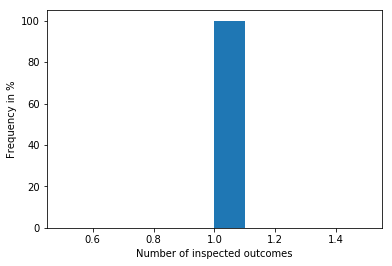

In [29]:
plt.figure()
plt.hist(hd_ls['nr_inspected_outcomes'])
plt.xlabel('Number of inspected outcomes')
plt.ylabel('Frequency in %')

print(np.sum(np.array(hd_ls['nr_inspected_outcomes'])==2))

print("The low-stakes policy inspected exactly 7 cells in {}% of the high-dispersion trials.".format(100*np.mean(np.array(hd_ls['nr_clicks'])==7)))
print("The low-stakes policy inspected fewer than 7 cells in {}% of the high-dispersion trials.".format(100*np.mean(np.array(hd_ls['nr_clicks'])<7)))
print("The low-stakes policy inspected more than 7 cells in {}% of the high-dispersion trials.".format(100*np.mean(np.array(hd_ls['nr_clicks'])>7)))
print("The low-stakes policy inspected more than 1 outcome in {}% of the high-dispersion trials.".format(100*np.mean(np.array(hd_ls['nr_inspected_outcomes'])>1)))

In  1e+02% of the high-dispersion problems, the low-stakes policy considered only the most probably outcome.

In the high-dispersion environment the BO policy made between 1 and 7 clicks. The average number of clicks was 3.6.

 Example: 
[[ 0.01  0.01  0.96  0.02]
 [ 0.    0.    1.    0.  ]
 [ 0.    0.    2.    0.  ]
 [ 0.    0.    3.    0.  ]
 [ 0.    0.    4.    0.  ]
 [ 0.    0.    5.    0.  ]
 [ 0.    0.    6.    0.  ]
 [ 0.    0.    7.    0.  ]]
[[ 0.072  0.003 -0.036  0.156]
 [ 0.011  0.009  0.231  0.021]
 [ 0.121  0.078  0.146  0.143]
 [ 0.093  0.175  0.132  0.257]
 [ 0.078  0.04   0.051  0.167]
 [ 0.236  0.166  0.163 -0.07 ]
 [ 0.116  0.181  0.31   0.13 ]]


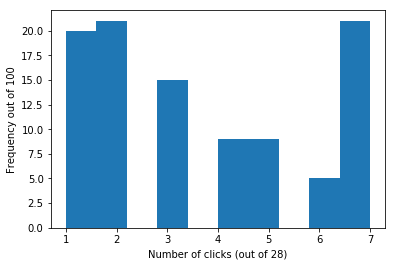

In [30]:
print("In {:6.3}% of the high-dispersion problems, the low-stakes policy considered only the most probably outcome.".format(100*np.mean(hd_ls['best_outcome_only'])))
print("")
avg_nr_clicks_hd_ls=np.mean(hd_ls['nr_clicks'])
min_nr_clicks_hd_ls=np.min(hd_ls['nr_clicks'])
max_nr_clicks_hd_ls=np.max(hd_ls['nr_clicks'])

print('In the high-dispersion environment the BO policy made between {} and {} clicks. The average number of clicks was {:3.2}.'.format(min_nr_clicks_hd_ls,max_nr_clicks_hd_ls,avg_nr_clicks_hd_ls))

plt.figure()
plt.hist(hd_ls['nr_clicks'])
plt.xlabel('Number of clicks (out of 28)')
plt.ylabel('Frequency out of 100')

print("\n Example: ")
print(hd_ls['p_grids'][0])
print(hd_ls_envs[0].grid())

## Properties of the low-stakes strategy in the high-dispersion environment

For a time cost of 0.5 cents per click the resource-rational strategy for the high-dispersion, low-stakes environment, is SAT-TTB or TTB in 100% of the trials. While this is similar to the high-dispersion, high-stakes condition, we also found a significant effect of the stakes: With lower stakes, the proportion of trials on which TTB is used decreases from 76% in the high-stakes condition to 39% in the low-stakes condition. Furthermore, strategies that inspect more than one attribute are no longer used in the low-stakes condition, and the average number of clicks decreases from 6.5 in the high-stakes conditoin to 4.5 clicks in the low-stakes condition.

Aspiration level after 1 clicks: 0.1700539239179874
Aspiration level after 2 clicks: 0.17479858924709915
Aspiration level after 3 clicks: 0.17878121898117824
Aspiration level after 4 clicks: 0.1794862985717349
Aspiration level after 5 clicks: 0.17705475814028107
average aspiration level: $0.17
average aspiration level: 0.556 standard deviations above mean


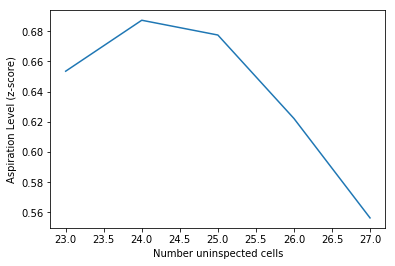

In [31]:
click_nrs = np.unique(hd_ls['nr_clicks'])
nr_clicks = np.array(hd_ls['nr_clicks'])
expected_returns = np.array(hd_ls['expected_term_rewards'])

aspiration_levels = dict()

for n in click_nrs[:-2]:
    print("Aspiration level after {} clicks: {}".format(n,np.min(expected_returns[nr_clicks==n])))
    aspiration_levels[n] = (np.min(expected_returns[nr_clicks==n])-mu_R_low_stakes)/sigma_R_low_stakes

plt.figure()
plt.plot(nr_alternatives*nr_outcomes-np.array([float(val) for val in aspiration_levels.keys()]),aspiration_levels.values())
plt.ylabel('Aspiration Level (z-score)')
plt.xlabel('Number uninspected cells')

aspiration_level = np.min(expected_returns[np.array(hd_ls['nr_clicks'])<nr_alternatives])
print('average aspiration level: ${:.3}'.format(aspiration_level))
print('average aspiration level: {:.3} standard deviations above mean'.format((aspiration_level-mu_R_low_stakes)/sigma_R_low_stakes))

#hd_hs['observations'][2]

# Low stakes, low dispersion

In [7]:
bo_pol_theta = np.load('data/low_stakes_1cents.npy')
bo_pol_low_stakes = LiederPolicy(list(bo_pol_theta))

cost = 0.01
reward = low_stakes
ld_ls_envs = [OldMouselabEnv(gambles, ld_dist(attributes), reward, cost) for _ in range(n_test)]

term_action = ld_ls_envs[0].term_action

In [8]:
#ld_ls = characterize_strategy(bo_pol_low_stakes,ld_ls_envs)
#save_obj(ld_ls,'low_dispersion_low_stakes_1cents')
ld_ls = load_obj('low_dispersion_low_stakes_1cents')

In [10]:
max_EV = np.array([])
all_actions = np.arange(28)
#for a in all_actions:
#    test_envs_hd[0].step(a)

for i in range(len(ld_ls_envs)):
    max_EV = np.append(max_EV,[expected_reward_of_termination(ld_ls_envs[i],all_actions)])
    
max_EV_ld_ls = np.mean(max_EV)

np.mean(ld_ls['returns'])/max_EV_ld_ls

print("The resource-rational strategy reaps {:.4}% of the highest possible payoffs.".format(100*np.mean(ld_ls['returns'])/max_EV_ld_ls))

The resource-rational strategy reaps 73.04% of the highest possible payoffs.


## Determine under which conditions the low-stakes policy inspects cells in the low-stakes, low-dispersion environment

In [21]:
nr_trials = len(ld_ls['nr_clicks'])

#for t in range(nr_trials):
np.array(ld_ls['nr_clicks'])==0

max_p = np.array([])
for t in range(nr_trials):
    max_p = np.append(max_p, [np.max(ld_ls['p_grids'][t][0])])
    

print("No cells are inspected if the largest probability is {:.4} or smaller.".format(np.max(max_p[np.array(ld_ls['nr_clicks'])==0])))
print("Cells are inspected if the largest probability is at least {:.4}.".format(np.min(max_p[np.array(ld_ls['nr_clicks'])>0])))

No cells are inspected if the largest probability is 0.3465 or smaller.
Cells are inspected if the largest probability is at least 0.35.


In [35]:
TTB_compatible = np.array([])
WADD_compatible = np.array([])
SAT_TTB_compatible = np.array([])
random_choice = np.array([])

for i in range(n_test):
    TTB_compatible =  np.append(TTB_compatible, [ld_ls['nr_clicks'][i]==nr_alternatives and ld_ls['best_outcome_only'][i]])
    WADD_compatible=  np.append(WADD_compatible,[ld_ls['nr_clicks'][i]==nr_alternatives*nr_outcomes])
    SAT_TTB_compatible = np.append(SAT_TTB_compatible, [ld_ls['best_outcome_only'][i] and ld_ls['nr_clicks'][i]>0])
    random_choice = np.append(random_choice, [ld_ls['nr_clicks'][i]==0])

print("On {}% of the low-dispersion trials the resource-rational strategy is random choice.".format(100*np.mean(random_choice)))
print("On {}% of the low-dispersion trials the click squences of the low-stakes policy were consistent with SAT-TTB.".format(100*np.mean(SAT_TTB_compatible)))
print("On {}% of the low-dispersion trials the click squences of the low-stakes policy were consistent with TTB.".format(100*np.mean(TTB_compatible)))
print("On {}% of the low-dispersion trials the click squences of the low-stakes policy was consistent with WADD.".format(100*np.mean(WADD_compatible)))

On 55.00000000000001% of the low-dispersion trials the resource-rational strategy is random choice.
On 45.0% of the low-dispersion trials the click squences of the low-stakes policy were consistent with SAT-TTB.
On 0.0% of the low-dispersion trials the click squences of the low-stakes policy were consistent with TTB.
On 0.0% of the low-dispersion trials the click squences of the low-stakes policy was consistent with WADD.


In [36]:
prop_alternative_based_clicks = np.mean(np.array(ld_ls['nr_alternative_based_clicks'])/(np.array(ld_ls['nr_clicks'])-1+0.00000001))
prop_attribute_based_clicks = np.mean(np.array(ld_ls['nr_attribute_based_clicks'])/(np.array(ld_ls['nr_clicks'])-1+0.00000001))
prop_other = 1 - (prop_alternative_based_clicks + prop_attribute_based_clicks)
#ld_ls['transitions_within_alternative']

print('In the low-dispersion environment {:.4}% of the clicks transitioned within the same attribute, {:.4}% transitioned within the same alternative, and the remaining {:.4}% of clicks switched both the attribute and the alternative.'.format(100*prop_attribute_based_clicks,100*prop_alternative_based_clicks,100*prop_other))

In the low-dispersion environment 23.0% of the clicks transitioned within the same attribute, 0.0% transitioned within the same alternative, and the remaining 77.0% of clicks switched both the attribute and the alternative.


The low-stakes policy inspected more than 7 cells in 0.0% of the low-dispersion trials.
The low-stakes policy inspected more than 1 outcome in 0.0% of the low-dispersion trials.


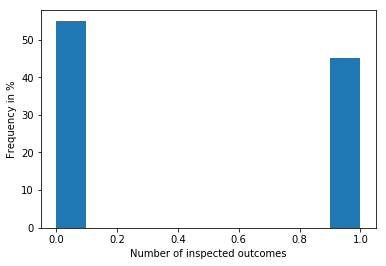

In [37]:
plt.figure()
plt.hist(ld_ls['nr_inspected_outcomes'])
plt.xlabel('Number of inspected outcomes')
plt.ylabel('Frequency in %')

print("The low-stakes policy inspected more than 7 cells in {}% of the low-dispersion trials.".format(100*np.mean(np.array(ld_ls['nr_clicks'])>7)))
print("The low-stakes policy inspected more than 1 outcome in {}% of the low-dispersion trials.".format(100*np.mean(np.array(ld_ls['nr_inspected_outcomes'])>1)))

In  1e+02% of the low-dispersion problems, the low-stakes policy considered only the most probable outcome.

In the low-dispersion environment the BO policy made between 0 and 6 clicks. The average number of clicks was 0.91.

On 22.0% of the low-stakes, low-dispersion environment the LC policy inspected only a single payoff.

On 9.0% of the low-stakes, low-dispersion environment the LC policy inspected only two payoffs.

 Example: 
[[ 0.19  0.35  0.22  0.24]
 [ 0.    1.    0.    0.  ]
 [ 0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.  ]]
[[ 0.256  0.283  0.11   0.143]
 [ 0.218  0.242  0.178  0.09 ]
 [ 0.063  0.138  0.123  0.175]
 [ 0.172  0.179  0.123  0.097]
 [ 0.175  0.12   0.137 -0.038]
 [ 0.027  0.008  0.088  0.053]
 [ 0.191  0.128  0.081  0.017]]


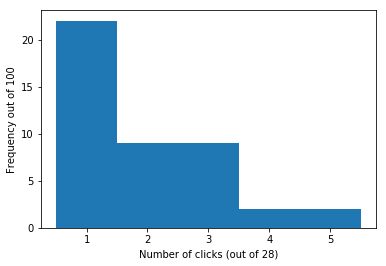

In [38]:
print("In {:6.3}% of the low-dispersion problems, the low-stakes policy considered only the most probable outcome.".format(100*np.mean(ld_ls['best_outcome_only'])))
print("")
avg_nr_clicks_ld_ls=np.mean(ld_ls['nr_clicks'])
min_nr_clicks_ld_ls=np.min(ld_ls['nr_clicks'])
max_nr_clicks_ld_ls=np.max(ld_ls['nr_clicks'])

print('In the low-dispersion environment the BO policy made between {} and {} clicks. The average number of clicks was {:3.2}.'.format(min_nr_clicks_ld_ls,max_nr_clicks_ld_ls,avg_nr_clicks_ld_ls))

print('\nOn {}% of the low-stakes, low-dispersion environment the LC policy inspected only a single payoff.'.format(100*np.mean(np.array(ld_ls['nr_clicks'])==1))) 
print('\nOn {}% of the low-stakes, low-dispersion environment the LC policy inspected only two payoffs.'.format(100*np.mean(np.array(ld_ls['nr_clicks'])==2))) 


plt.figure()
plt.hist(ld_ls['nr_clicks'],bins=np.arange(0.5,np.max(ld_ls['nr_clicks'])+0.5,1))
plt.xlabel('Number of clicks (out of 28)')
plt.ylabel('Frequency out of 100')

print("\n Example: ")
print(ld_ls['p_grids'][13])
print(ld_ls_envs[13].grid())

## Properties of the low-stakes strategy in the low-dispersion environment

In the *low-stakes, low-dispersion environment* with a cost of 0.5 cents per click, SAT-TTB was resource-rational for 69% of the problems. TTB was resource-rational for 6% of those problems. This means that for 63% of the problems SAT-TTB was resource-rational and did not inspect all of the outcomes. Neither random choice or WADD were resource-rational for any of these problems.

Comparing these numbers to the high-dispersion environment with low-stakes reveals a 31% decrease in the use of SAT-TTB for low-dispersion compared to high-dispersion. This makes sense given that SAT-TTB is a non-compensatory strategy. 

Despite all outcomes being almost equally likely, the resource-rational strategy was predominantly attribute-based rather than alternative based: 68.6% of the clicks transitioned within the same attribute whereas only 0.6604% transitioned within the same alternative, and the remaining 30.74% of clicks switched both the attribute and the alternative.

The number of clicks ranged from 1 to 12, and the average number of clicks was 4.1. Consistent with the small number of clicks, the aspiration level was consistently low -- at most requiring the payoff to be at last 0.154 standard deviations above the mean. This is 9 clicks fewer than in the condition with high-stakes and low-dispersion. This illustrates the effect of stakes on the resource-rational planning.

In the 31% of problems where SAT-TTB was not used, it started with SAT-TTB, encountered a near-tie between two promising gambles and then started inspected those gambles' payoffs for other outcomes. Interestingly, in resolving those ties, the LC policy often inspected an additional payoff of the second-best gamble. If that payoff was low, then the it was ruled out and the current-best gamble was chosen. If the second-best gamble's second payoff was similar to the first one, then the LC policy inspected a second payoff for the current-best gamble, and so on.

Aspiration level after 0 clicks: 0.12999999999999998
Aspiration level after 1 clicks: 0.1308783026613502
Aspiration level after 2 clicks: 0.13357498622637456
Aspiration level after 3 clicks: 0.14543901556354616
Aspiration level after 4 clicks: 0.15958624148519135
average aspiration level: $0.13
average aspiration level: -3.85e-16 standard deviations above mean


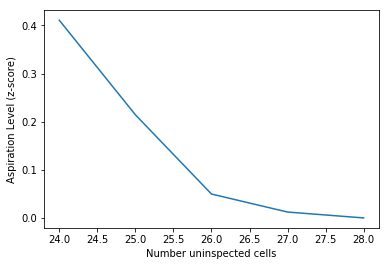

In [39]:
click_nrs = np.unique(ld_ls['nr_clicks'])
nr_clicks = np.array(ld_ls['nr_clicks'])
expected_returns = np.array(ld_ls['expected_term_rewards'])

aspiration_levels = dict()

for n in click_nrs[:-2]:
    print("Aspiration level after {} clicks: {}".format(n,np.min(expected_returns[nr_clicks==n])))
    aspiration_levels[n] = (np.min(expected_returns[nr_clicks==n])-mu_R_low_stakes)/sigma_R_low_stakes

plt.figure()
plt.plot(nr_alternatives*nr_outcomes-np.array([float(val) for val in aspiration_levels.keys()]),aspiration_levels.values())
plt.ylabel('Aspiration Level (z-score)')
plt.xlabel('Number uninspected cells')

aspiration_level = np.min(expected_returns[np.array(ld_ls['nr_clicks'])<nr_alternatives])
print('average aspiration level: ${:.3}'.format(aspiration_level))
print('average aspiration level: {:.3} standard deviations above mean'.format((aspiration_level-mu_R_low_stakes)/sigma_R_low_stakes))


In [40]:
#Save the results
save_obj(ld_ls, 'high_dispersion_low_stakes' )

## Summary statistics

In [43]:
(avg_nr_clicks_hd_hs+avg_nr_clicks_ld_hs)/2

9.9049999999999994

In [44]:
(avg_nr_clicks_hd_ls+avg_nr_clicks_ld_ls)/2

2.2799999999999998

In [46]:
[[avg_nr_clicks_ld_ls,avg_nr_clicks_hd_ls],[avg_nr_clicks_ld_hs,avg_nr_clicks_hd_hs]]

[[0.91000000000000003, 3.6499999999999999], [12.84, 6.9699999999999998]]

In [59]:
[[np.mean(ld_ls['returns']),np.mean(hd_ls['returns'])],[np.mean(ld_hs['returns']),np.mean(hd_hs['returns'])]]

[[0.13081510007929201, 0.16715715463520681],
 [6.5405111010425401, 8.5964534744329164]]